# Temporal Convolutional Network
In this notebook, we show an example of how TCNs can be used with darts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models.tcn_model import TCNModel
from darts.preprocessing import ScalerWrapper
from darts.metrics import mape
from darts.utils.missing_values import auto_fillna
from darts.backtesting import backtest_forecasting

In [2]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
ts = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp('19580801'))

In [3]:
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(ts)

In [4]:
my_model = TCNModel(
    n_epochs=1000, 
    input_length=20, 
    output_length=5, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3
)

[2020-06-16 12:11:34,988] INFO | darts.models.tcn_model | Number of layers chosen: 2
INFO:darts.models.tcn_model:Number of layers chosen: 2


In [5]:
my_model.fit(train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.0117, validation loss: 0.0732


26


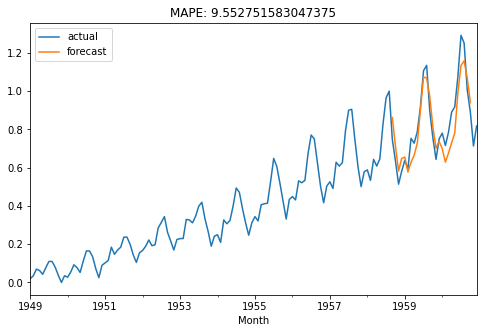

In [6]:
def eval_model(model):
    pred_series = model.predict(n=26)
    print(len(pred_series))
    plt.figure(figsize=(8,5))
    ts_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {}'.format(mape(pred_series.slice_intersect(val_transformed), val_transformed)))
    plt.legend();
    
eval_model(my_model)